Import libraries and define k

In [585]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Read data and split it to train and test sets. Define k.

In [586]:
k = 2
n_test = 100

data = np.loadtxt( "MLoGPU_data1_train.csv", delimiter = ",", dtype = np.float32 )
x_data = np.array( data[ :, 0:-1 ] )
y_data = np.array( data[ :, -1 ] ).reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split( x_data, y_data, test_size = n_test )


Defining kernel code

In [587]:
kernel_code = """
  __global__ void euclidean_distance( float* a, float* b, float* c, int vec_length, int vec_num) {

    int thread_index = blockIdx.x * blockDim.x + threadIdx.x;
    float term_diff = 0;
    float difference = 0;
    
    if ( thread_index > vec_num  ) {
      return;
    }

    for ( int ii = 0; ii < vec_length; ++ii ) {
      
      term_diff = 0;

      int vec_index = vec_length*thread_index + ii;
    
      term_diff = b[ii] - a[ vec_index ];
      difference += term_diff*term_diff;
      
      __syncthreads();

    }

    c[ thread_index ] = sqrtf( difference );
    
   
  }
"""

Defining constants and block and grid dims

In [588]:
N_training = X_train.shape[0]
N_features = X_train.shape[1]

if N_training < 1024:
  THREADS = N_training
else:
  THREADS = 1024

gridDim = int( np.ceil( N_training/THREADS ) )
block_dims = ( THREADS, 1, 1 )
grid_dims = ( gridDim, 1, 1 )

Doing the classification

In [589]:
# Compile the kernel code
modd = SourceModule( kernel_code )
dist_fun = modd.get_function( "euclidean_distance" )

# Allocate memroy to GPU
training_vecs_gpu = cuda.mem_alloc( X_train.nbytes )
cuda.memcpy_htod( training_vecs_gpu, X_train )

distances = np.empty( [ N_training, 1 ], dtype = np.float32 )
distances_gpu = cuda.mem_alloc( distances.nbytes )

predicted_labels = []

# For each test vector
for ii in range( X_test.shape[0] ):
    
    test_vec = X_test[ ii, : ]

    test_vec_gpu = cuda.mem_alloc( test_vec.nbytes )
    cuda.memcpy_htod( test_vec_gpu, test_vec )

    # Executing the kernel
    dist_fun( training_vecs_gpu, test_vec_gpu, distances_gpu, np.int32( N_features ), np.int32( N_training ),
              block = block_dims, grid = grid_dims )

    cuda.memcpy_dtoh( distances, distances_gpu )
    
    # Sorting the distances 
    distance_data = np.concatenate( ( distances, Y_train ), axis = 1 )
    
    ind = np.argsort( distance_data[ :, 0 ] )
    sorted_distances = distance_data[ ind ]
    
    label_predicted = max( set( sorted_distances[ 0:k, 1 ] ) )
    
    predicted_labels.append( label_predicted )
    
predicted_labels = np.array( predicted_labels )
    

Visualizing results

[3. 4. 5. 6. 7. 8. 9.]
[ 0  2 17 43 30  8]
6


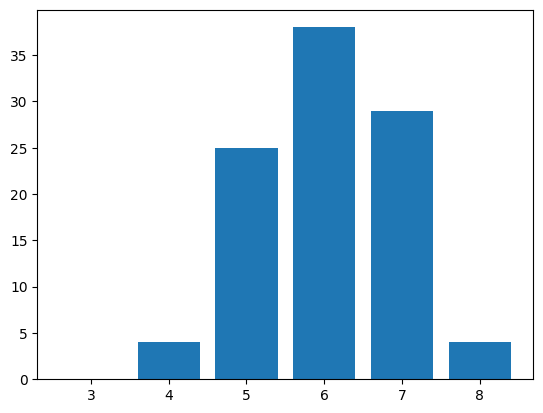

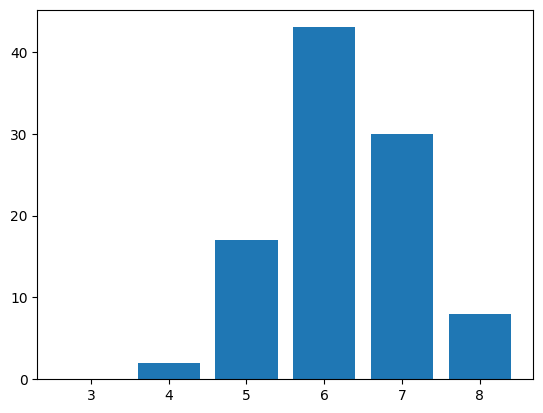

In [590]:
unique_labels = np.unique( data[ :, -1 ] )

Y_test_bins = np.bincount( np.squeeze( Y_test ).astype( np.int16 ) )[3:]
predicted_bins = np.bincount( np.squeeze( predicted_labels ).astype( np.int16 ) )[3:]

plt.bar( unique_labels[ 0:len( Y_test_bins )], Y_test_bins ) 
plt.show()

plt.bar( unique_labels[ 0:len( predicted_bins ) ], predicted_bins )
plt.show()